In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy.optimize as opt
import scipy.io as sio
%matplotlib inline

In [2]:
data = sio.loadmat('ex5data1.mat')
Xtest = data['Xtest']
Xval = data['Xval']
X = data['X']
y = data['y']
ytest = data['ytest']
yval = data['yval']

m = X.shape[0]

In [3]:
def linearRegCostFunction(theta,X,y,lam):
    m = X.shape[0]
    h = X.dot(theta) - np.squeeze(y)
    J = (1.0/(2*m))*(h.T.dot(h)) + ((lam/(2.0*m))*theta[1:].dot(theta[1:]))
    grad = (1.0/m)*(X.T.dot(h) + lam*np.concatenate([[0],theta[1:]]))
    return J,grad

theta = np.ones(2)
J,grad = linearRegCostFunction(theta,np.concatenate([np.ones([m,1]),X],1),y,1)
print "Cost at theta = [1;1] :"
print J
print "Gradient:"
print grad

Cost at theta = [1;1] :
303.99319222
Gradient:
[ -15.30301567  598.25074417]


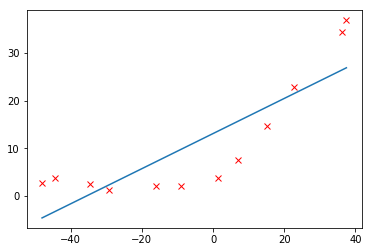

In [4]:
def trainLinearReg(X,y,lam):
    initial_theta = np.ones(X.shape[1])
    theta = opt.minimize(fun=linearRegCostFunction,x0 = initial_theta,args=(X,y,lam),method='TNC', jac=True, options={'maxiter': 200} )
    return theta

lam = 0
X1 = np.concatenate([np.ones([X.shape[0],1]),X],1)
res = trainLinearReg(X1,y,lam)
theta = res.x
plt.plot(X,y,'rx')

X_plt = np.ones([2,2])
X_plt[0,1] = np.min(X)
X_plt[1,1] = np.max(X)
h_plt = X_plt.dot(theta)

plt.plot(X_plt[:,1],h_plt)

[  8.63153419e-18   8.37104465e-18   3.28659505e+00   2.84267769e+00
   1.31540488e+01   1.94439625e+01   2.00985217e+01   1.81728587e+01
   2.26094054e+01   2.32614616e+01   2.43172496e+01   2.23739065e+01]
[ 169.87070841  110.30036585   45.01023123   48.36891147   35.86516421
   33.82996175   31.97098573   30.86244629   31.13599806   28.93620722
   29.55143198   29.4338178 ]


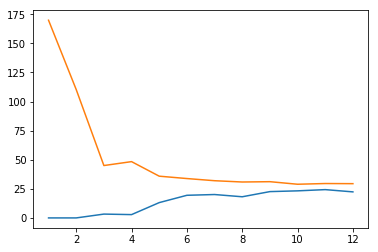

In [5]:
def learningCurve(X,y,Xval,yval,lam):
    m = X.shape[0]
    error_train = np.zeros(m)
    error_val = np.zeros(m)
    for i in xrange(m):
        res = trainLinearReg(X[:i+1],y[:i+1],lam)
        theta_train = res.x
        error_train[i], buf =  linearRegCostFunction(theta_train,X[:i+1],y[:i+1],0)
        error_val[i], buf = linearRegCostFunction(theta_train,Xval,yval,0)
    return error_train,error_val

lam = 0
error_train,error_val = learningCurve(np.concatenate([np.ones([m,1]),X],1),y,np.concatenate([np.ones([Xval.shape[0],1]),Xval],1),yval,lam)
print error_train
print error_val
plt.plot(np.arange(1,m+1),error_train,np.arange(1,m+1),error_val)

In [6]:
def polyFeatures(X,p):
    res = X
    for i in xrange(2,p+1):
        res = np.column_stack([res,X**i]) #column stack seems to work even if the input vector is in (x,)  size form
    return res


def featureNormalize(X):
    mu = X.mean(0)
    X = X - mu
    std = X.std(0,ddof=1)
    X = X/std
    return X,mu,std
    
p=8
Xpoly = polyFeatures(X,p)
Xpoly,mu,std = featureNormalize(Xpoly)
Xpoly = np.concatenate([np.ones([Xpoly.shape[0],1]),Xpoly],1)

Xpoly_test = polyFeatures(Xtest,p)
Xpoly_test = Xpoly_test - mu
Xpoly_test = Xpoly_test/std
Xpoly_test = np.concatenate([np.ones([Xpoly_test.shape[0],1]),Xpoly_test],1)

Xpoly_val = polyFeatures(Xval,p)
Xpoly_val = Xpoly_val - mu
Xpoly_val = Xpoly_val/std
Xpoly_val = np.concatenate([np.ones([Xpoly_val.shape[0],1]),Xpoly_val],1)

print "Normalized training example 1: "
print Xpoly[0,:]

Normalized training example 1: 
[ 1.         -0.36214078 -0.75508669  0.18222588 -0.70618991  0.30661792
 -0.59087767  0.3445158  -0.50848117]


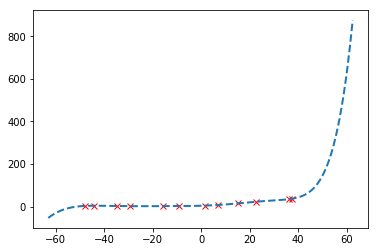

In [7]:
def plotFit(min_x,max_x,mu,sigma,theta,p):
    x = np.arange(min_x-15,max_x+25,0.05)
    X_poly = polyFeatures(x,p)
    X_poly = X_poly - mu
    X_poly = X_poly/sigma
    X_poly = np.column_stack([np.ones([x.shape[0],1]),X_poly])
    plt.plot(x, X_poly.dot(theta), '--', lw=2)
    
lam = 0
res = trainLinearReg(Xpoly,y,lam)
theta = res.x
plt.plot(X,y,'rx')
plotFit(np.min(X),np.max(X),mu,std,theta,p)

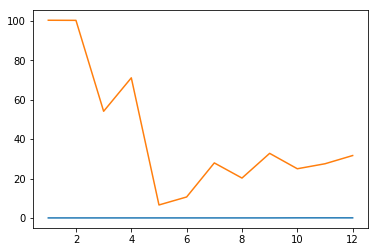

In [8]:
lam = 0
error_train,error_val = learningCurve(Xpoly,y,Xpoly_val,yval,lam)
plt.plot(np.arange(1,m+1),error_train,np.arange(1,m+1),error_val)

[  0.0324343    0.1125226    0.17088805   0.22149861   0.28184314
   0.45932547   0.92169338   2.0761872    4.90135006  16.09221727]
[ 31.67545153   9.81942097  16.29215076  16.94267805  12.83067966
   7.58676122   4.63697439   4.26062248   3.82290635   9.94551086]


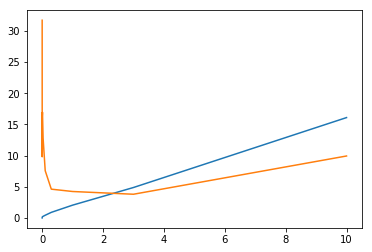

In [9]:
def validationCurve(X,y,Xval,yval):
    lambda_vec = np.array([0, 0.001, 0.003, 0.01, 0.03, 0.1, 0.3, 1, 3, 10])
    error_train = np.zeros(lambda_vec.size)
    error_val = np.zeros(lambda_vec.size)
    for i in xrange(lambda_vec.size):
        lam = lambda_vec[i]
        res = trainLinearReg(X,y,lam)
        theta_train = res.x
        error_train[i],buf = linearRegCostFunction(theta_train,X,y,0)
        error_val[i],buf = linearRegCostFunction(theta_train,Xval,yval,0)
    return lambda_vec,error_train,error_val

lam_vec,error_train,error_val = validationCurve(Xpoly,y,Xpoly_val,yval)
print error_train
print error_val

plt.plot(lam_vec,error_train,lam_vec,error_val)

In [10]:
lam = 3
res = trainLinearReg(Xpoly,y,lam)
theta_train = res.x
error_test, buf = linearRegCostFunction(theta_train,Xpoly_test,ytest,0)
print "Test error:"
print error_test

Test error:
3.85988767389
